In [1]:
import numpy as np
from tqdm import tqdm
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# distance and its tests
def distance(N, node_1, node_2):
    ''' Distance from node_1 to node_2 via the base graph '''
    if node_1 >= node_2: return node_1 - node_2
    else: return N - node_2 + node_1

# some simple tests for the distance    
assert distance(5, 4, 3) == 1
assert distance(5, 0, 4) == 1
assert distance(5, 3, 4) == 4
assert distance(5, 1, 4) == 2

In [3]:
def navigation(source, destination, shortcuts):
    ''' Perform greedy routing on the ring graph s->d using shortcuts or base graph '''
    
    # number of nodes
    N = len(shortcuts)
    
    # initial vertex
    current_vertex = source
    
    # path
    path = [current_vertex]
    
    # waiting until done
    while current_vertex != destination:
        # going down or via the shortcut
        option_0 = (current_vertex - 1) % N
        option_1 = shortcuts[current_vertex]

        # -1 means no shortcut
        if option_1 < 0:
            options = [option_0]
        else:
            # all options
            options = [option_0, option_1]
        
        # distances from option to destination
        distances = [distance(N, x, destination) for x in options]
        
        # GREEDY: choosing the least distance
        choice = options[np.argmin(distances)]
        
        # updating current vertex
        current_vertex = choice
        path.append(current_vertex)
        
    # returing path
    return path

# simple tests
N = 5

# all lead to 0
shortcuts = [0, 0, 0, 0, 0]
assert navigation(4, 0, shortcuts) == [4, 0]

# all lead to 4
shortcuts = [4, 4, 4, 4, 4]
assert navigation(4, 0, shortcuts) == [4, 3, 2, 1, 0]

# shortcut 3->1
shortcuts = [4, 4, 4, 1, 4]
assert navigation(4, 0, shortcuts) == [4, 3, 1, 0]

# no shortcuts
shortcuts = [-1, -1, -1, -1, -1]
assert navigation(4, 0, shortcuts) == [4, 3, 2, 1, 0]

In [4]:
def get_tau(shortcuts, repetitions = 100, tqdm = lambda x : x):
    ''' Perform routing from random to random points using shortcuts and return routing times '''
    
    # resulting times
    results = []
    
    # number of nodes
    N = len(shortcuts)
    
    # loop over repetitions
    for i in tqdm(range(repetitions)):
        # choosing s and d
        source = np.random.choice(range(N))
        destination = np.random.choice(range(N))
        
        # performing navigation
        t = navigation(source, destination, shortcuts)
        
        # storing its length
        results.append(len(t))
        
    # returing array of times
    return results

In [5]:
def rewire_1(shortcuts, p):
    # number of nodes
    N = len(shortcuts)
    
    # choosing source and destination at random
    source = np.random.choice(range(N))
    destination = np.random.choice(range(N))
    
    # doing nothing in degenerate case
    if source == destination:
        return np.copy(shortcuts)
    
    # performing a greedy walk
    walk = navigation(source, destination, shortcuts)
    
    # choosing vertices to rewire
    do_rewire = np.random.rand(len(walk)) <= p
    
    # creating a copy of shortcuts
    new_shortcuts = np.copy(shortcuts)
    
    # rewiring vertices
    for i, vertex in enumerate(walk):
        # if selected with prob. p, set to destination
        if do_rewire[i]: new_shortcuts[vertex] = destination
            
    # returning result
    return new_shortcuts

## Demo: decay of $\tau$ while rewiring

In [6]:
# number of vertices in the ring graph
# Vertices: 0, ..., N-1
# connections (base graph): x+1 -> x and 0 -> N - 1
# + shortcuts
N = 20000

# choosing the rewiring probability
p = 0.1

# initially have no shortcuts
shortcuts = [-1] * N

# choosing number of repetitions for tau estimation
repetitions = 50

# choosing number of rewirings
rewirings = 3000

# experiment
tau_means = []
tau_stds = []

# estimate tau each K iterations
K = 100

for i in tqdm(range(rewirings)):
    shortcuts = rewire_1(shortcuts, p)
    if i % K == 0 and i > 0:
        tau = get_tau(shortcuts, repetitions = repetitions)
        tau_means.append(np.mean(tau))
        tau_stds.append(np.std(tau))
    #print('Iteration %d, tau = %f' % (i, tau_mean))

100%|██████████| 3000/3000 [01:32<00:00, 32.45it/s]


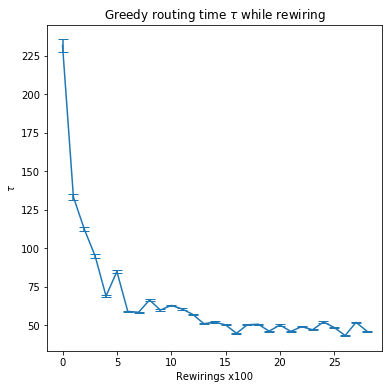

In [7]:
plt.figure(figsize = (6, 6))
plt.title('Greedy routing time $\\tau$ while rewiring')
plt.xlabel('Rewirings x' + str(K))
plt.ylabel('$\\tau$')
# variance of the mean is 1 / n * variance of one
plt.errorbar(range(len(tau_means)), tau_means, yerr = np.array(tau_stds) / repetitions, capsize = 5)
plt.show()

## Reproducing Figure 1

In [6]:
def estimate_tau_after_rewiring(N = 20000, p = 0.1, repetitions = 10000, rewirings = 200000):
    '''
    Estimate the mean routing time after rewiring the graph using the algorithm proposed
    
    N -- number of vertices in the graph
    p -- probability of rewiring in the algorithm
    repetitions -- number of estimates for the mean time
    rewirings -- number of rewirings performed
    
    '''
    # initially have 0 shortcuts
    shortcuts = [-1] * N

    # rewiring the graph
    for i in tqdm(range(rewirings)):
        shortcuts = rewire_1(shortcuts, p)

    # calculating the tau
    return shortcuts, get_tau(shortcuts, repetitions = repetitions, tqdm = tqdm)

Test of the function

In [7]:
shortcuts, tau = estimate_tau_after_rewiring(N = 10000, p = 0.1, repetitions = 10, rewirings = 100)

100%|██████████| 10/10 [00:00<00:00, 60.08it/s]


In [8]:
tau

[144, 191, 178, 126, 117, 214, 36, 52, 72, 47]

Calculating with parameters from the paper

In [9]:
# from 1000 to 100000
N_arr = np.logspace(3, 5, 10)

# probability of rewiring
p = 0.1

# rewirings number
rewirings = 5000

# number for the MC estimate of tau
repetitions = 500

results = [estimate_tau_after_rewiring(N = int(N), p = p, repetitions = repetitions, rewirings = rewirings) for N in N_arr]

100%|██████████| 500/500 [00:42<00:00, 11.83it/s]


In [13]:
taus = np.array([x[1] for x in results])

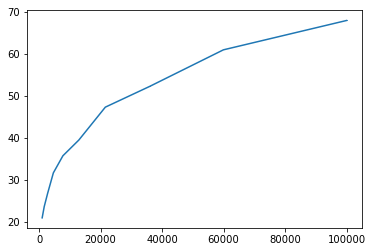

In [21]:
plt.figure()
plt.errorbar(N_arr, np.mean(taus, axis = 1), yerr = np.std(taus, axis = 1) / repetitions)
plt.show()

In [38]:
#import pickle
#pickle.dump(results, open('results1.pkl', 'wb'))
#results = pickle.load(open('results1.pkl', 'rb'))